In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
from PIL import Image
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
# Hyperparameters
batch_size = 32
epochs = 2
learning_rate = 0.001
image_size = (224, 224)

In [49]:
# Paths
train_image_dir = "../data/images/train"
train_label_file = "../data/attribute_matrix_train.txt"
test_image_dir = "../data/images/test"
test_label_file = "../data/attribute_matrix_test.txt"


# Transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [50]:
def process_group_labels(group_labels):

    found_one = False
    processed_labels = []
    
    for idx, value in enumerate(group_labels):
        if value == 1 and not found_one:
            processed_labels.append(1)
            found_one = True
        else:
            processed_labels.append(0)
    
    # Wenn keine 1 gefunden wurde, setze das erste Element auf 1
    if not found_one:
        processed_labels[0] = 1
    
    return processed_labels


In [51]:
class GroupedImageDataset(Dataset):
    def __init__(self, image_dir, label_file, attribute_groups, transform=None, undersample=False, random_state=1):

        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True))
        raw_labels = np.loadtxt(label_file, dtype=int)
        self.attribute_groups = attribute_groups
        self.transform = transform

        # Prepare grouped labels
        self.labels = [
            {group: torch.tensor(process_group_labels([label[idx] for idx in indices]), dtype=torch.long).argmax()
             for group, indices in attribute_groups.items()}
            for label in raw_labels
        ]

        if undersample:
            all_indices = np.arange(len(self.image_paths))
            for group in attribute_groups.keys():
                # Extract labels for the current group
                group_labels = np.array([label[group].item() for label in self.labels])

                # Debugging: check group_labels
                print(f"Group '{group}' - group_labels: {group_labels[:10]}")  # print first 10 for debugging

                # Skip undersampling if group_labels is empty
                if group_labels.size == 0:
                    print(f"Warning: No labels found for group '{group}'. Skipping undersampling for this group.")
                    continue

                # Perform undersampling
                rus = RandomUnderSampler(random_state=random_state)
                indices = all_indices.reshape(-1, 1)  # Indices as features for resampling

                # Debugging: check indices shape
                print(f"Group '{group}' - Indices shape: {indices.shape}")

                try:
                    resampled_indices, _ = rus.fit_resample(indices, group_labels)
                    resampled_indices = resampled_indices.flatten()

                    # Ensure resampled indices do not exceed available images
                    resampled_indices = resampled_indices[resampled_indices < len(self.image_paths)]
                    print(f"After truncating, resampled indices size: {len(resampled_indices)}")

                    # Subset images and labels based on valid resampled indices
                    self.image_paths = [self.image_paths[i] for i in resampled_indices]
                    self.labels = [self.labels[i] for i in resampled_indices]
                    all_indices = resampled_indices  # Update indices for the next group

                    # Print balancing info for the group
                    print(f"After undersampling for group '{group}':")
                    unique, counts = np.unique([group_labels[i] for i in resampled_indices], return_counts=True)
                    print(dict(zip(unique, counts)))

                except ValueError as e:
                    print(f"Error during undersampling for group '{group}': {e}")

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [52]:
#DEFINE THE MODEL
class ResNetGroupedMultiClass(nn.Module):
    def __init__(self, attribute_groups):
        super(ResNetGroupedMultiClass, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.dropout = nn.Dropout(0.5)
        self.group_classifiers = nn.ModuleDict({
            group_name: nn.Linear(in_features, len(indices))
            for group_name, indices in attribute_groups.items()
        })

    def forward(self, x):
        features = self.resnet(x)
        features = self.dropout(features)
        outputs = {
            group_name: classifier(features)
            for group_name, classifier in self.group_classifiers.items()
        }
        return outputs

In [53]:
# Attribute Groups
attribute_groups = {
    "has_bill_shape": list(range(0, 9)),
    "has_wing_color": list(range(9, 24)),
    "has_upperparts_color": list(range(24, 39)),
    "has_underparts_color": list(range(39, 54)),
    "has_breast_pattern": list(range(54, 58)),
    "has_back_color": list(range(58, 73)),
    "has_tail_shape": list(range(73, 79)),
    "has_upper_tail_color": list(range(79, 94)),
    "has_head_pattern": list(range(94, 105)),
    "has_breast_color": list(range(105, 120)),
    "has_throat_color": list(range(120, 135)),
    "has_eye_color": list(range(135, 149)),
    "has_bill_length": list(range(149, 152)),
    "has_forehead_color": list(range(152, 167)),
    "has_under_tail_color": list(range(167, 182)),
    "has_nape_color": list(range(182, 197)),
    "has_belly_color": list(range(197, 212)),
    "has_wing_shape": list(range(212, 217)),
    "has_size": list(range(217, 222)),
    "has_shape": list(range(222, 236)),
    "has_back_pattern": list(range(236, 240)),
    "has_tail_pattern": list(range(240, 244)),
    "has_belly_pattern": list(range(244, 248)),
    "has_primary_color": list(range(248, 263)),
    "has_leg_color": list(range(263, 278)),
    "has_bill_color": list(range(278, 293)),
    "has_crown_color": list(range(293, 308)),
    "has_wing_pattern": list(range(308, 312)),
}

In [54]:
train_dataset = GroupedImageDataset(train_image_dir, train_label_file, attribute_groups, transform, undersample=True)
train_dataset.image_paths

Group 'has_bill_shape' - group_labels: [0 4 4 5 5 1 7 7 4 4]
Group 'has_bill_shape' - Indices shape: (5994, 1)
After truncating, resampled indices size: 837
After undersampling for group 'has_bill_shape':
{0: 93, 1: 93, 2: 93, 3: 93, 4: 93, 5: 93, 6: 93, 7: 93, 8: 93}
Group 'has_wing_color' - group_labels: [ 1  8  0 14  0  5 11 11 11  7]
Group 'has_wing_color' - Indices shape: (837, 1)
After truncating, resampled indices size: 7
After undersampling for group 'has_wing_color':
{5: 2, 6: 1, 11: 4}
Group 'has_upperparts_color' - group_labels: [11  5  5  5  1  5  0]
Group 'has_upperparts_color' - Indices shape: (7, 1)
After truncating, resampled indices size: 0
After undersampling for group 'has_upperparts_color':
{}
Group 'has_underparts_color' - group_labels: []
Group 'has_breast_pattern' - group_labels: []
Group 'has_back_color' - group_labels: []
Group 'has_tail_shape' - group_labels: []
Group 'has_upper_tail_color' - group_labels: []
Group 'has_head_pattern' - group_labels: []
Group '

[]

In [55]:
def class_count(group, class_idx, labels):

    count = 0
    for label in labels:
        if label[group] == class_idx:
            
            count += 1
    return count

In [56]:
#TODO - adjust weights, because it does not work properly
# Berechnung der Häufigkeiten und Gewichte
group_class_frequencies = {
    group: torch.tensor(
        [class_count(group, class_idx, train_dataset.labels) for class_idx in range(len(indices))],
        dtype=torch.float32
    )
    for group, indices in attribute_groups.items()
}
group_class_frequencies

{'has_bill_shape': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_wing_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_upperparts_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_underparts_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_breast_pattern': tensor([0., 0., 0., 0.]),
 'has_back_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_tail_shape': tensor([0., 0., 0., 0., 0., 0.]),
 'has_upper_tail_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_head_pattern': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_breast_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_throat_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_eye_color': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'has_bill_length': tensor([0

In [57]:
train_dataset = GroupedImageDataset(train_image_dir, train_label_file, attribute_groups, transform)
test_dataset = GroupedImageDataset(test_image_dir, test_label_file, attribute_groups, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_dataset.labels[0]

{'has_bill_shape': tensor(0),
 'has_wing_color': tensor(5),
 'has_upperparts_color': tensor(5),
 'has_underparts_color': tensor(5),
 'has_breast_pattern': tensor(0),
 'has_back_color': tensor(5),
 'has_tail_shape': tensor(2),
 'has_upper_tail_color': tensor(5),
 'has_head_pattern': tensor(0),
 'has_breast_color': tensor(12),
 'has_throat_color': tensor(5),
 'has_eye_color': tensor(10),
 'has_bill_length': tensor(2),
 'has_forehead_color': tensor(5),
 'has_under_tail_color': tensor(5),
 'has_nape_color': tensor(5),
 'has_belly_color': tensor(12),
 'has_wing_shape': tensor(0),
 'has_size': tensor(1),
 'has_shape': tensor(13),
 'has_back_pattern': tensor(0),
 'has_tail_pattern': tensor(0),
 'has_belly_pattern': tensor(0),
 'has_primary_color': tensor(5),
 'has_leg_color': tensor(1),
 'has_bill_color': tensor(13),
 'has_crown_color': tensor(5),
 'has_wing_pattern': tensor(0)}

In [58]:
def class_count(group, class_idx, labels):
    """
    Berechnet die Häufigkeit einer Klasse in einer Gruppe basierend auf den Labels.
    - group: Name der Attributgruppe (z. B. "has_wing_color").
    - class_idx: Index der Klasse innerhalb der Gruppe.
    - labels: Liste der Trainingslabels.
    """
    count = 0
    for label in labels:
        if label[group] == class_idx:
            count += 1
    return count

In [59]:
#TODO - adjust weights, because it does not work properly
# Berechnung der Häufigkeiten und Gewichte
group_class_frequencies = {
    group: torch.tensor(
        [class_count(group, class_idx, train_dataset.labels) for class_idx in range(len(indices))],
        dtype=torch.float32
    )
    for group, indices in attribute_groups.items()
}

group_weights = {
    group: 1.0 / (group_class_frequencies[group] + 1e-6)
    for group in attribute_groups.keys()
}

# Normalisierung der Gewichte
group_weights = {
    group: weights / weights.sum()
    for group, weights in group_weights.items()
}

# Erstellung der Verlustfunktion
'''
criterion = {
    group: nn.CrossEntropyLoss(weight=group_weights[group].to(device))
    for group in attribute_groups.keys()
}

'''
criterion = {
    group: nn.CrossEntropyLoss()
    for group in attribute_groups.keys()
}

In [60]:
# Model, Loss, and Optimizer
model = ResNetGroupedMultiClass(attribute_groups).to(device)
#criterion = {group: nn.CrossEntropyLoss() for group in attribute_groups.keys()}
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [13]:
def train_grouped_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = {group: 0 for group in attribute_groups.keys()}
        total_samples = {group: 0 for group in attribute_groups.keys()}

        for images, labels in train_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}

            optimizer.zero_grad()
            outputs = model(images)
            loss = sum(criterion[group](outputs[group], labels[group]) for group in outputs)/len(outputs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            for group in outputs:
                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)

        for group in correct_predictions:
            acc = correct_predictions[group]/total_samples[group]
            print(f"accuracy for group {group}: {acc}")
        # Calculate epoch accuracy
        total_accuracy = sum(correct_predictions[group] for group in correct_predictions) / sum(total_samples[group] for group in total_samples)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Total Accuracy: {total_accuracy:.4f}")

In [14]:
# Evaluation Function
def evaluate_grouped_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = {group: 0 for group in attribute_groups.keys()}
    total_samples = {group: 0 for group in attribute_groups.keys()}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)

            for group in outputs:
                loss = criterion[group](outputs[group], labels[group])
                total_loss += loss.item()

                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)
            
    for group in correct_predictions:
        acc = correct_predictions[group]/total_samples[group]
        print(f"accuracy for group {group}: {acc}")

    # Calculate overall accuracy
    total_accuracy = sum(correct_predictions[group] for group in correct_predictions) / sum(total_samples[group] for group in total_samples)
    print(f"Total Loss: {total_loss:.4f}, Total Accuracy: {total_accuracy:.4f}")

In [15]:
train_grouped_model(model, train_loader, criterion, optimizer, epochs=epochs)


accuracy for group has_bill_shape: 0.36920253586920254
accuracy for group has_wing_color: 0.2772772772772773
accuracy for group has_upperparts_color: 0.25308641975308643
accuracy for group has_underparts_color: 0.2415749082415749
accuracy for group has_breast_pattern: 0.639305972639306
accuracy for group has_back_color: 0.2434100767434101
accuracy for group has_tail_shape: 0.302635969302636
accuracy for group has_upper_tail_color: 0.3630296963630297
accuracy for group has_head_pattern: 0.23473473473473475
accuracy for group has_breast_color: 0.2315648982315649
accuracy for group has_throat_color: 0.2704371037704371
accuracy for group has_eye_color: 0.7959626292959626
accuracy for group has_bill_length: 0.574240907574241
accuracy for group has_forehead_color: 0.24357691024357692
accuracy for group has_under_tail_color: 0.28061394728061395
accuracy for group has_nape_color: 0.2087087087087087
accuracy for group has_belly_color: 0.2679346012679346
accuracy for group has_wing_shape: 0.6279

In [16]:

evaluate_grouped_model(model, test_loader, criterion)

accuracy for group has_bill_shape: 0.41974456334138766
accuracy for group has_wing_color: 0.38280980324473596
accuracy for group has_upperparts_color: 0.3703831549879185
accuracy for group has_underparts_color: 0.3444943044528823
accuracy for group has_breast_pattern: 0.6356575768035899
accuracy for group has_back_color: 0.33983431135657577
accuracy for group has_tail_shape: 0.3369002416292717
accuracy for group has_upper_tail_color: 0.38419054193993785
accuracy for group has_head_pattern: 0.2666551605108733
accuracy for group has_breast_color: 0.33051432516396273
accuracy for group has_throat_color: 0.3610631687953055
accuracy for group has_eye_color: 0.8110113910942354
accuracy for group has_bill_length: 0.6304798066965827
accuracy for group has_forehead_color: 0.3565757680358992
accuracy for group has_under_tail_color: 0.31532619951674146
accuracy for group has_nape_color: 0.32809803244735936
accuracy for group has_belly_color: 0.35381429064549536
accuracy for group has_wing_shape: 

In [17]:
# 6. Save Model
torch.save(model.state_dict(), '../models/grouped_attribute_predictor.pth')

In [18]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, attribute_groups, num_examples=5):
    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if examples_shown >= num_examples:
                    return
                
                # Image
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.229) + 0.485  # Rückgängig machen der Normalisierung
                image = np.clip(image, 0, 1)

                # True Labels
                true_labels = {group: labels[group][i].item() for group in attribute_groups.keys()}
                
                # Predicted Labels
                predicted_labels = {group: torch.argmax(outputs[group], dim=1)[i].item() for group in attribute_groups.keys()}
                
                # Plot
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.axis('off')
                
                # True und Predicted Labels anzeigen
                plt.title(
                    f"True: {true_labels}\nPredicted: {predicted_labels}",
                    fontsize=8, loc='left', wrap=True
                )
                plt.show()
                
                examples_shown += 1


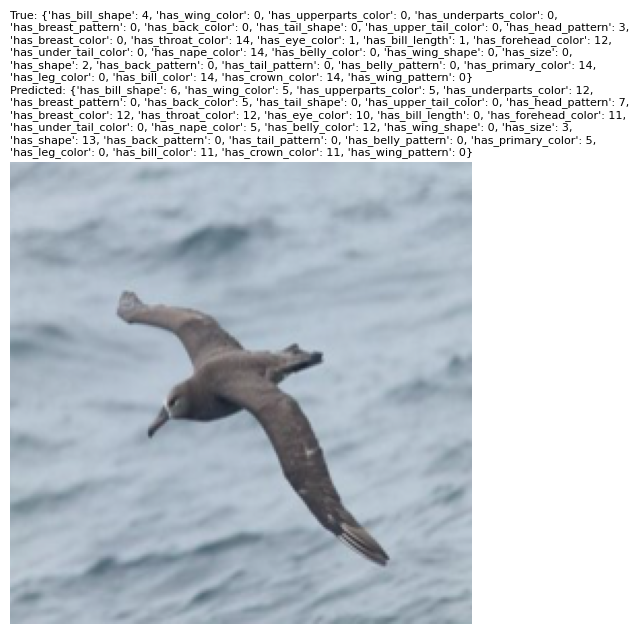

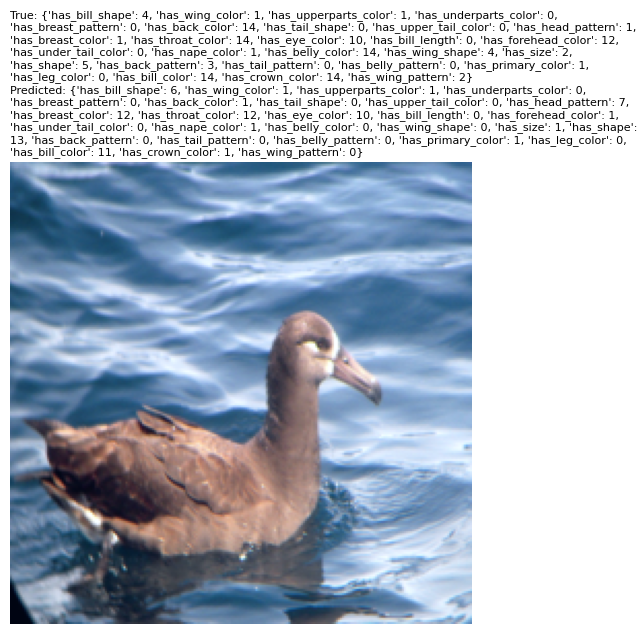

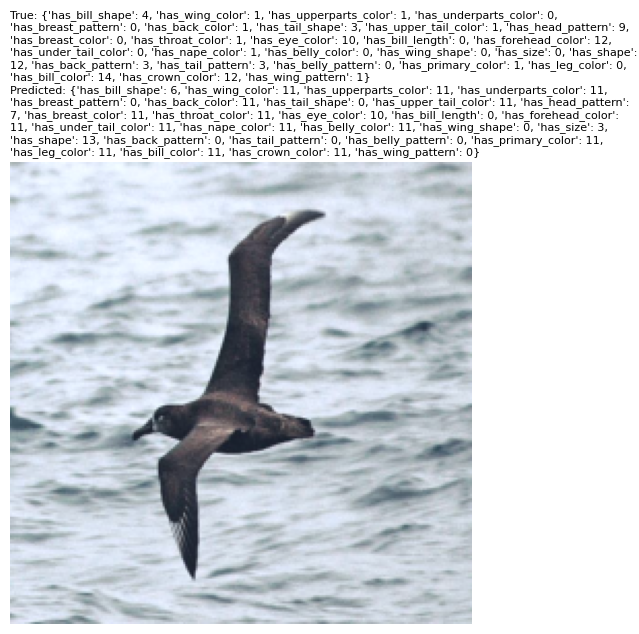

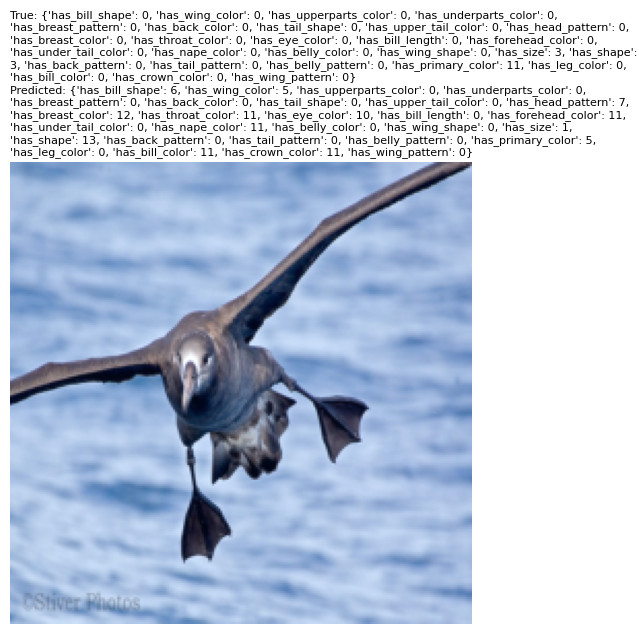

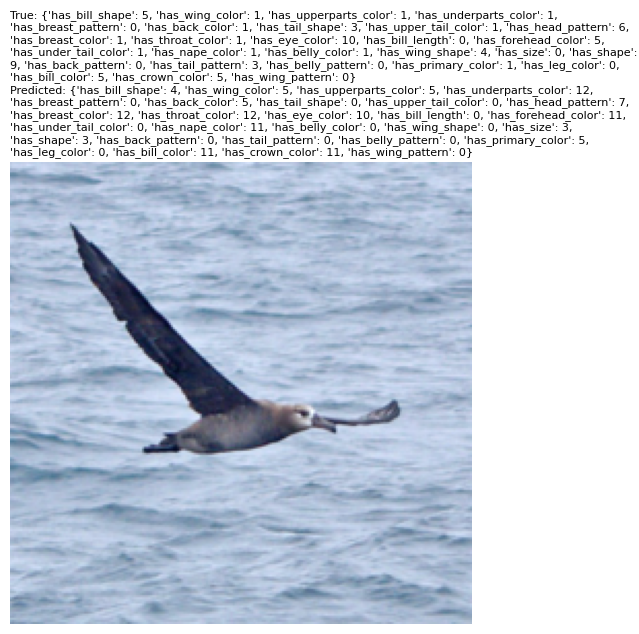

In [19]:
visualize_predictions(model, test_loader, attribute_groups, num_examples=5)


In [20]:
def load_attribute_mapping(file_path, attribute_groups):
    """
    Lädt die Attributzuordnung und berücksichtigt die Gruppen.
    
    Args:
        file_path (str): Pfad zur Attributnamen-Datei.
        attribute_groups (dict): Dictionary der Attributgruppen.
    
    Returns:
        dict: Mapping von Gruppen zu Listen von Attributnamen.
    """
    attribute_mapping = {group: [] for group in attribute_groups.keys()}
    
    with open(file_path, 'r') as f:
        for line in f:
            index, attribute = line.strip().split(" ", 1)
            index = int(index) - 1  # Nullbasierter Index
            
            attribute_name = attribute.split("::", 1)[-1]
            # Finde, zu welcher Gruppe der Index gehört
            for group, indices in attribute_groups.items():
                if index in indices:
                    attribute_mapping[group].append(attribute_name)
                    break
    
    return attribute_mapping


In [21]:
attribute_mapping = load_attribute_mapping("../data/attributes.txt", attribute_groups)


In [22]:
def visualize_predictions_with_names(model, data_loader, attribute_groups, attribute_mapping, num_examples=5):
    """
    Visualisiert einige Beispiele mit Bild, True Labels und Vorhersagen in Namenform.
    
    Args:
        model (nn.Module): Das trainierte Modell.
        data_loader (DataLoader): DataLoader für das Dataset.
        attribute_groups (dict): Dictionary der Attributgruppen.
        attribute_mapping (dict): Mapping der Gruppen zu Attributnamen.
        num_examples (int): Anzahl der Beispiele zur Visualisierung.
    """
    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if examples_shown >= num_examples:
                    return
                
                # Bild verarbeiten
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.229) + 0.485  # Normalisierung rückgängig machen
                image = np.clip(image, 0, 1)

                # True und Predicted Labels
                true_labels = {
                    group: attribute_mapping[group][labels[group][i].item()]
                    for group in attribute_groups.keys()
                }
                predicted_labels = {
                    group: attribute_mapping[group][torch.argmax(outputs[group], dim=1)[i].item()]
                    for group in attribute_groups.keys()
                }

                # Plot
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.axis('off')
                
                # True und Predicted Labels anzeigen
                plt.title(
                    f"True: {true_labels}\nPredicted: {predicted_labels}",
                    fontsize=8, loc='left', wrap=True
                )
                plt.show()
                
                examples_shown += 1


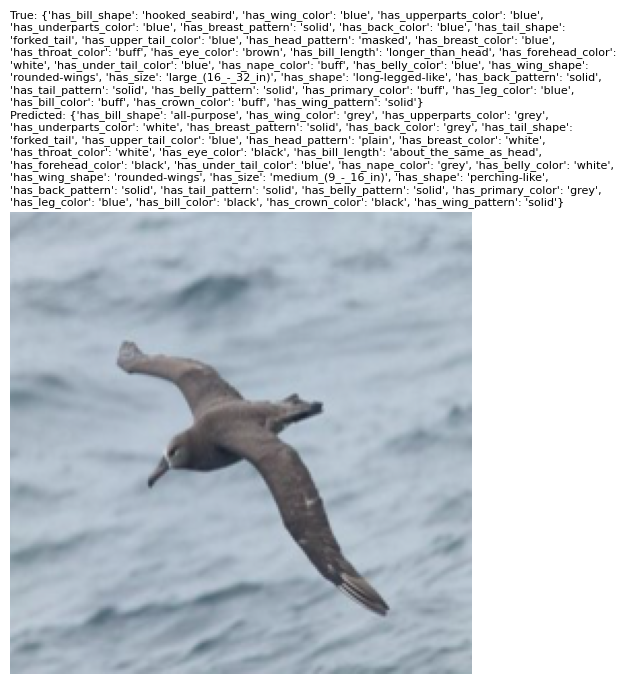

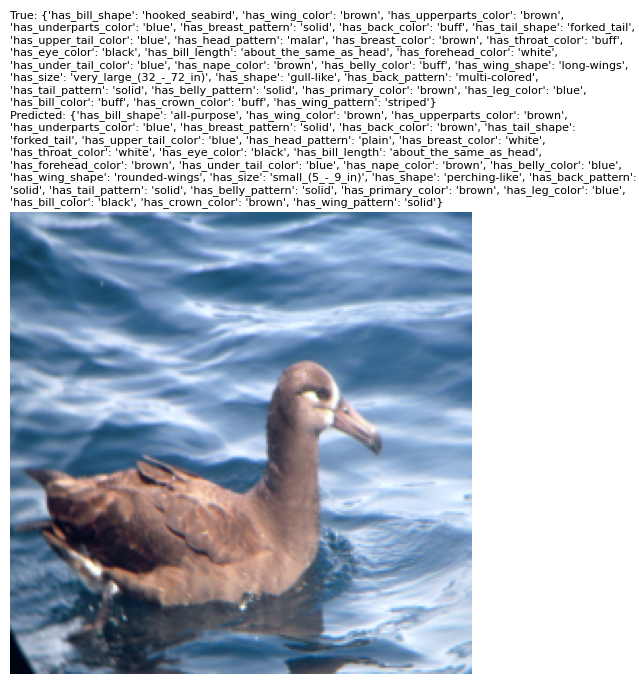

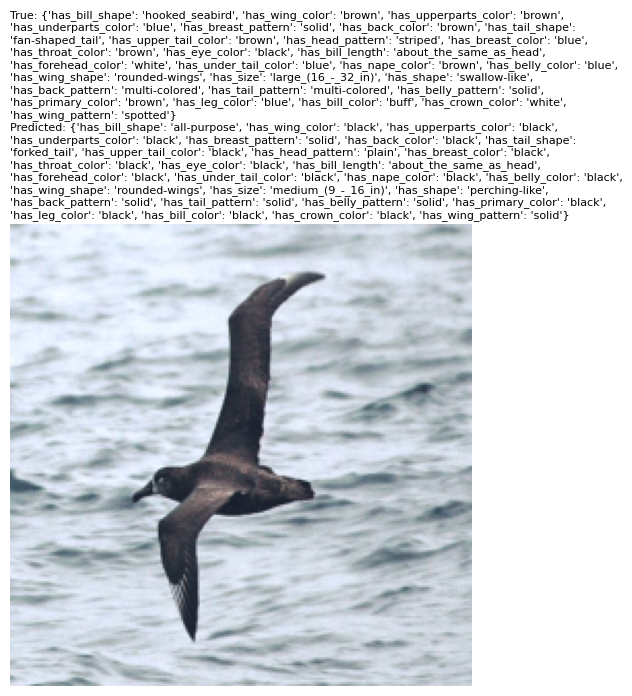

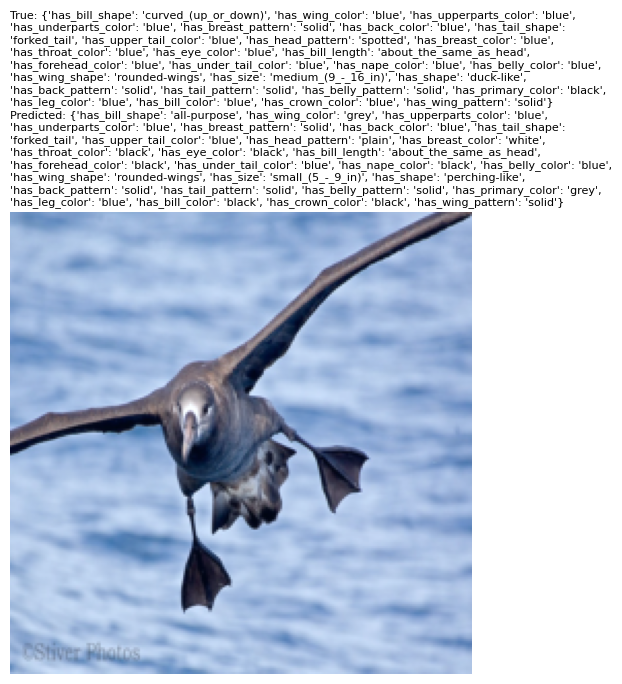

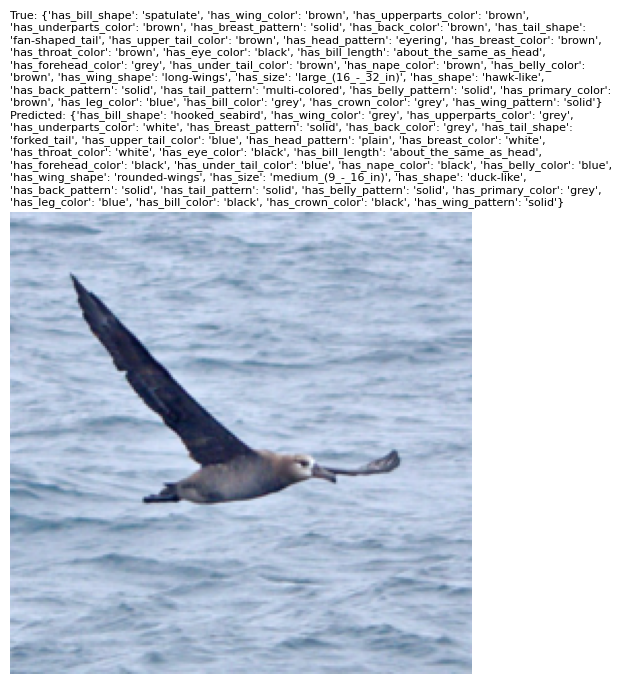

In [23]:
visualize_predictions_with_names(model, test_loader, attribute_groups, attribute_mapping, num_examples=5)

# Hyperparameters
batch_size = 32<br>
epochs = 6<br>
learning_rate = 0.001<br>
image_size = (224, 224)<br>
<br>
data are preprocessed, of per group there are no 1, then first 1 is assigned. if per group is multiple 1 then only first 1 is kept.<br>
Accuracy:<br>
accuracy for group has_bill_shape: 0.41974456334138766<br>
accuracy for group has_wing_color: 0.38280980324473596<br>
accuracy for group has_upperparts_color: 0.3703831549879185<br>
accuracy for group has_underparts_color: 0.3444943044528823
accuracy for group has_breast_pattern: 0.6356575768035899<br>
accuracy for group has_back_color: 0.33983431135657577<br>
accuracy for group has_tail_shape: 0.3369002416292717<br>
accuracy for group has_upper_tail_color: 0.38419054193993785<br>
accuracy for group has_head_pattern: 0.2666551605108733<br>
accuracy for group has_breast_color: 0.33051432516396273<br>
accuracy for group has_throat_color: 0.3610631687953055<br>
accuracy for group has_eye_color: 0.8110113910942354<br>
accuracy for group has_bill_length: 0.6304798066965827<br>
accuracy for group has_forehead_color: 0.3565757680358992<br>
accuracy for group has_under_tail_color: 0.31532619951674146<br>
accuracy for group has_nape_color: 0.32809803244735936<br>
accuracy for group has_belly_color: 0.35381429064549536<br>
accuracy for group has_wing_shape: 0.6216775975146703<br>
accuracy for group has_size: 0.561442871936486<br>
accuracy for group has_shape: 0.5236451501553331<br>
accuracy for group has_back_pattern: 0.5802554366586123<br>
accuracy for group has_tail_pattern: 0.597859855022437<br>
accuracy for group has_belly_pattern: 0.6922678633068692<br>
accuracy for group has_primary_color: 0.3898860890576458<br>
accuracy for group has_leg_color: 0.2889195719710045<br>
accuracy for group has_bill_color: 0.3598550224370038<br>
accuracy for group has_crown_color: 0.35795650673110113<br>
accuracy for group has_wing_pattern: 0.41594753192958234<br>
Total Loss: 7994.3969, Total Accuracy: 0.4413<br>

Klassen verteilung ist auch imbalanced:
{'has_bill_shape': tensor([ 306.,  805.,   93.,  140.,  378.,  245., 2281., 1614.,  132.]),
 'has_wing_color': tensor([ 772., 1602.,   78.,   13.,   49., 1454.,  270.,  127.,   44.,   12.,
           67., 1194.,  137.,   44.,  131.]),
 'has_upperparts_color': tensor([1105., 1457.,  111.,   16.,   51., 1384.,  268.,  120.,   38.,   11.,
           72., 1022.,  164.,   61.,  114.]),
 'has_underparts_color': tensor([ 758.,  613.,   78.,   10.,   72., 1011.,  744.,   76.,   31.,   25.,
          120.,  658., 1302.,  134.,  362.]),
 'has_breast_pattern': tensor([3852.,  370.,  699., 1073.]),
 'has_back_color': tensor([1550., 1207.,   78.,   17.,   38., 1212.,  238.,  120.,   37.,   18.,
           42.,  972.,  213.,   70.,  182.]),
 'has_tail_shape': tensor([1543.,  649., 1792.,  478., 1042.,  490.]),
 'has_upper_tail_color': tensor([2207.,  888.,   50.,   11.,   36.,  966.,  158.,   94.,   30.,   30.,
           49., 1014.,  230.,   72.,  159.]),
 'has_head_pattern': tensor([ 461.,  551.,  216.,  233.,  187.,  622.,  832., 1483.,  542.,  326.,
          541.]),
 'has_breast_color': tensor([ 656.,  697.,   58.,    7.,   75., 1005.,  679.,   63.,   25.,   21.,
          124.,  794., 1256.,  155.,  379.]),
 'has_throat_color': tensor([ 467.,  502.,   70.,   18.,   74.,  884.,  615.,   52.,   26.,   21.,
           85., 1077., 1515.,  174.,  414.]),
 'has_eye_color': tensor([ 362.,  190.,    6.,   66.,  107.,  102.,   11.,   12.,   19.,   88.,
         4796.,   98.,   93.,   44.]),
 'has_bill_length': tensor([2319.,  350., 3325.]),
 'has_forehead_color': tensor([ 608., 1065.,   76.,   27.,   86., 1078.,  401.,   84.,   21.,   18.,
           98., 1485.,  437.,  199.,  311.]),
 'has_under_tail_color': tensor([1756.,  946.,   57.,   10.,   47., 1057.,  216.,   90.,   27.,   18.,
           44., 1194.,  320.,   42.,  170.]),
 'has_nape_color': tensor([ 764., 1040.,   88.,   23.,   75., 1247.,  339.,   96.,   35.,   23.,
           74., 1141.,  596.,  133.,  320.]),
 'has_belly_color': tensor([ 823.,  521.,   65.,    9.,   59.,  932.,  735.,   68.,   35.,   18.,
          121.,  578., 1486.,  136.,  408.]),
 'has_wing_shape': tensor([3788., 1147.,  340.,  427.,  292.]),
 'has_size': tensor([ 216., 3072.,  114., 1167., 1425.]),
 'has_shape': tensor([ 150.,  112.,   67.,  369.,   23.,  420.,  271.,  369.,  412.,  176.,
          283.,  188.,  243., 2911.]),
 'has_back_pattern': tensor([3475.,  387.,  987., 1145.]),
 'has_tail_pattern': tensor([3594.,  274.,  797., 1329.]),
 'has_belly_pattern': tensor([4162.,  341.,  616.,  875.]),
 'has_primary_color': tensor([ 377., 1485.,   75.,   35.,   68., 1459.,  514.,  116.,   42.,   23.,
          110., 1044.,  333.,   95.,  218.]),
 'has_leg_color': tensor([1150.,  475.,   24.,   23.,   55., 1475.,   90.,   10.,    7.,  118.,
          466., 1227.,   90.,  146.,  638.]),
 'has_bill_color': tensor([ 286.,  500.,   57.,   12.,   78., 1552.,  288.,   24.,    8.,   35.,
          351., 2058.,  110.,  144.,  491.]),
 'has_crown_color': tensor([ 626., 1138.,   75.,   20.,   94., 1143.,  338.,   84.,   27.,   19.,
           81., 1483.,  368.,  212.,  286.]),
 'has_wing_pattern': tensor([2357.,  460., 1464., 1713.])}